In [ ]:
# This is the first model that began seeing success in the classification
# The inputs are properly normalized (not between 0 and 1) in accordance with the resnet50.preprocess function
# Image augmentation is included to prevent overfitting

# This is also the first notebook document with cleaned up and annotated code

In [1]:
# setup

import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import glob
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

TRAIN_DIR = 'data/train/*'
TEST_DIR = 'data/test/*'
IMG_SIZE = 300
IMG_DIM = (IMG_SIZE, IMG_SIZE)
LR = 2e-5

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, 'resnet')

NUMBER_TRAINING_FILES = 10000
NUMBER_VAL_FILES = 1000

BATCH_SIZE = 64

In [2]:
# get training and validation files

train_files = glob.glob(TRAIN_DIR) 
train_imgs = []
for index, item in tqdm(enumerate(train_files)):
    if index < NUMBER_TRAINING_FILES:
        train_imgs.append(img_to_array(load_img(item, target_size=IMG_DIM)))
    else:
        pass
    
validation_imgs = []
for index, item in tqdm(enumerate(train_files)):
    if index > NUMBER_TRAINING_FILES and index < NUMBER_TRAINING_FILES + NUMBER_VAL_FILES:
        validation_imgs.append(img_to_array(load_img(item, target_size=IMG_DIM)))
    else:
        pass

25000it [00:14, 1696.07it/s]
25000it [00:01, 12525.23it/s] 


In [3]:
# convert files from lists/tuples to numpy arrays (better for memory)

train_imgs = np.array(train_imgs)
validation_imgs = np.array(validation_imgs)

In [4]:
# labelling

train_labels = []
for index, item in tqdm(enumerate(train_files)):
    if index < NUMBER_TRAINING_FILES:
        train_labels.append(item.split('/')[-1].split('.')[0].strip())
    else:
        pass
    
validation_labels = []
for index, item in tqdm(enumerate(train_files)):
    if index > NUMBER_TRAINING_FILES and index < NUMBER_TRAINING_FILES + NUMBER_VAL_FILES:
        validation_labels.append(item.split('/')[-1].split('.')[0].strip())
    else:
        pass

25000it [00:00, 1504758.62it/s]
25000it [00:00, 4401527.94it/s]


In [5]:
# image processing for resnet 50

import tensorflow

train_imgs = tensorflow.keras.applications.resnet50.preprocess_input(train_imgs)
validation_imgs = tensorflow.keras.applications.resnet50.preprocess_input(validation_imgs)

In [6]:
# label encoding, ie dogs = 1 cats = 0

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)

train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

In [7]:
#image augmentation- note that the ImageDataGenerator function is actually deprecated, need to fix later

train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
 horizontal_flip=True, fill_mode='nearest')
validation_datagen = ImageDataGenerator()

In [8]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc,batch_size=BATCH_SIZE)
val_generator = validation_datagen.flow(validation_imgs, validation_labels_enc, batch_size=BATCH_SIZE)

In [9]:
# download restnet50 architecture and imagenet weights

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import keras

restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))

output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)

restnet = Model(inputs=restnet.input, outputs=output)

for layer in restnet.layers:
    layer.trainable = False

Metal device set to: Apple M2


2022-08-19 14:55:35.606083: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-19 14:55:35.606478: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# create full neural network

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(restnet)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
# sigmoid typically used for binary predictions
model.add(Dense(1, activation='sigmoid')) 

# binary crossentropy typically used for binary predictions
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=LR),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 204800)            23587712  
                                                                 
 dense (Dense)               (None, 512)               104858112 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 128,708,993
Trainable params: 105,121,281


In [11]:
history = model.fit(train_generator, epochs=15, validation_data=val_generator, verbose=1)

Epoch 1/15


2022-08-19 14:55:52.582640: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-19 14:55:53.855147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9294

2022-08-19 15:00:03.506523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 279s 2s/step - loss: 0.2219 - accuracy: 0.9294 - val_loss: 0.0448 - val_accuracy: 0.9830
Epoch 2/15
157/157 [==============================] - 362s 2s/step - loss: 0.1094 - accuracy: 0.9630 - val_loss: 0.0362 - val_accuracy: 0.9880
Epoch 3/15
157/157 [==============================] - 381s 2s/step - loss: 0.1021 - accuracy: 0.9704 - val_loss: 0.0945 - val_accuracy: 0.9780
Epoch 4/15
157/157 [==============================] - 407s 3s/step - loss: 0.0995 - accuracy: 0.9701 - val_loss: 0.0604 - val_accuracy: 0.9830
Epoch 5/15
157/157 [==============================] - 423s 3s/step - loss: 0.0893 - accuracy: 0.9730 - val_loss: 0.0438 - val_accuracy: 0.9910
Epoch 6/15
157/157 [==============================] - 391s 2s/step - loss: 0.0999 - accuracy: 0.9716 - val_loss: 0.0519 - val_accuracy: 0.9890
Epoch 7/15
157/157 [==============================] - 341s 2s/step - loss: 0.0909 - accuracy: 0.9749 - val_loss: 0.0699 - val_accuracy: 0.9860
Epoch 8/15

In [12]:
# save neural network

model.save('models/' + MODEL_NAME)

INFO:tensorflow:Assets written to: models/dogsvscats-2e-05-resnet.model/assets


INFO:tensorflow:Assets written to: models/dogsvscats-2e-05-resnet.model/assets


In [13]:
# save training progress data

import pickle
with open('noaugment_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [14]:
# functions for model predictions

def get_photo(path):
    train_imgs = []
    train_imgs.append(img_to_array(load_img(path, target_size=IMG_DIM)))
    process = np.array(train_imgs)
    process = tensorflow.keras.applications.resnet50.preprocess_input(process)
    return process

In [20]:
def predict(path):
    return model.predict( get_photo(path) )

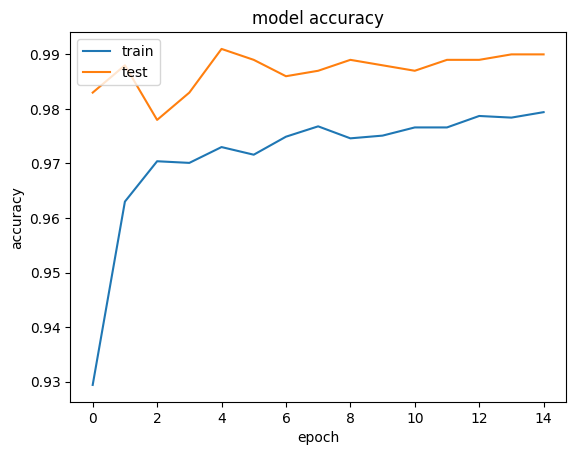

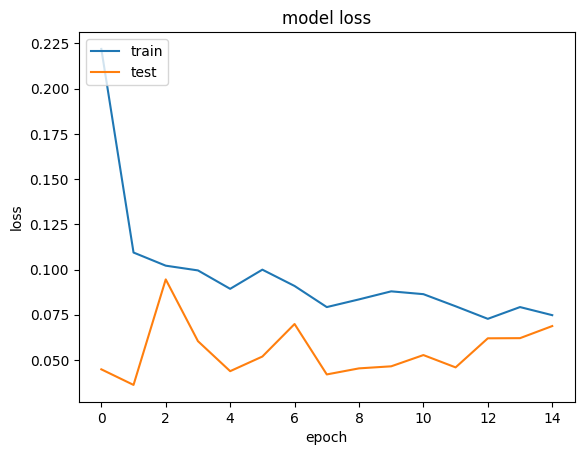

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
predict('data/test/38.jpg')

1/1 [==============================] - 0s 22ms/step


array([[1.9880173e-16]], dtype=float32)

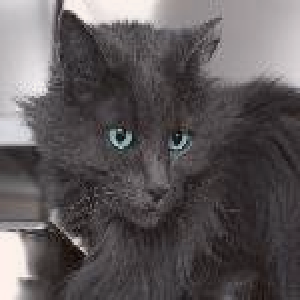

In [27]:
array_to_img(get_photo('data/test/38.jpg')[0])